<div style="display: flex; align-items: center; justify-content: center; flex-wrap: wrap;">
    <div style="flex: 1; max-width: 400px; display: flex; justify-content: center;">
        <img src="https://diretorio.bad.pt/wp-content/uploads/2015/09/55c9dc4270c60-IMS-rgb_logo.png" style="max-width: 50%; height: auto; margin-top: 50px; margin-bottom: 50px;margin-left: 6rem;">
    </div>
    <div style="flex: 2; text-align: center; margin-top: 20px;margin-left: 8rem;">
        <div style="font-size: 28px; font-weight: bold; line-height: 1.2;">
            <span style="color:rgb(190, 214, 47);">CIFO Project |</span> <span style="color:rgb(92, 102, 108);">Sports League Optimization using Genetic Algorithms</span>
        </div>
        <div style="font-size: 17px; font-weight: bold; margin-top: 10px;">
            Spring Semester | 2024 - 2025
        </div>
        <div style="font-size: 17px; font-weight: bold;">
            Master in Data Science and Advanced Analytics
        </div>
        <div style="margin-top: 20px;">
            <div>Diogo Duarte, 20240525</div>
            <div>Rodrigo Sardinha, 20211627</div>
            <div>Rui Luz, 20211628</div>
        </div>
        <div style="margin-top: 20px; font-weight: bold;">
            Group AE
        </div>
    </div>
</div>

<div style="background: linear-gradient(to right,rgb(190, 214, 47), rgb(92, 102, 108));
            padding: 1px; color: white; border-radius: 500px; text-align: center;">
</div>

# 📋 **0. Table of Contents**

# 🔎 **1. Project Overview**

The **goal** of this project is to apply **Genetic Algorithms** to solve an optimization problem.

### ⚽ **1.1. Optimization Problem Idea #2: Sports League Optimization**

In  a  fantasy  sports  league,  the  objective  is  to  assign  players  to  teams  in  a  way  that  ensures a balanced distribution of talent while staying within salary caps.

Each player is defined by the following attributes:
- **Skill rating**: Represents the player's ability.
- **Cost**: The player's salary.
- **Position**: One of four roles: Goalkeeper (GK), Defender (DF), Midfielder (MF), and Forward (FW).

A solution is a complete league configuration, specifying the team assignment for each player.


### ⛔ **1.2. Constraints**:

No object is considered a solution if it doesn't comply with:
 - Each team must consist of: 1 Goalkeeper, 2 Defenders, 2 Midfielders, and 2 Forwards.
 - Each player is assigned to exactly one team.

In [42]:
team_size = 7 # teams of 7 players
num_teams = 5 # 5 teams to be created
budget_limit = 750 # in €M
team_structure = {"GK": 1, "DEF": 2, "MID": 2, "FWD": 2} # each team must consist of this structure

# Fixed values to start from
population_size = 30 
generations = 100

# 📚 2. Imports

In [43]:
import pandas as pd
import random

from utils.Classes import Player, Team, LeagueIndividual
from algorithms.GA_mutation import mutation_swap_players, mutation_regenerate_team, mutation_balance_teams
from algorithms.GA_crossover import team_crossover, position_crossover
from algorithms.GA_selection import sel_roulette, sel_rank, sel_tournament
from algorithms.algorithm import genetic_algorithm 
from solutions.GASolution import GASolution
from utils.combinations import evaluate_all_combinations  


import matplotlib.pyplot as plt
from collections import Counter

In [44]:
df = pd.read_csv("data/players.csv")
df = df.drop(columns=['Unnamed: 0']) # drop the index column

# Convert DF to player objects

In [45]:
players_by_position = {
    pos: [Player.from_dict(row) for _, row in df[df['Position'] == pos].iterrows()]
    for pos in team_structure
}

# Generate Population

In [46]:
# Setting the initial iteration
def generate_initial_population(size, players_by_position, team_structure, budget_limit, num_teams):
    """
    Generate an initial population of LeagueIndividuals.
    Each individual is a LeagueIndividual object that represents a league of teams.

    Args:
        size (int): The number of individuals to generate.
        players_by_position (dict): A dictionary where keys are positions and values are lists of Player objects.
        team_structure (dict): A dictionary defining the structure of each team (e.g., number of players per position).
        budget_limit (float): The budget limit for the league.
        num_teams (int): The number of teams in the league.
    """
    population = []
    attempts = 0
    max_attempts = 1000 # avoid infinite loop if unable to generate valid leagues

    while len(population) < size and attempts < max_attempts:
        indiv = LeagueIndividual(players_by_position, team_structure, budget_limit, num_teams)
        if indiv.league is not None: # proceed if the league is valid
            population.append(indiv)
        attempts += 1

    return population

# Generate the initial iteration
population = generate_initial_population(
    population_size,
    players_by_position,
    team_structure,
    budget_limit, 
    num_teams
)

### Testing population generation

In [47]:
# Print the entire population
def print_population(population):
    """
    Print the details of each individual in the population.
    Each individual is a LeagueIndividual object that represents a league of teams.

    Args:
        population (list): A list of LeagueIndividual objects.
    """
    for i, indiv in enumerate(population):
        print(f"\nLeague {i+1} | Fitness: {indiv.fitness:.4f}")
        print()
        all_names = set()
        for j, team in enumerate(indiv.league): # iterate through each team in the league
            names = [p.name for p in team.players]
            positions = [p.position for p in team.players]
            skill = team.avg_skill()
            salary = team.total_salary()
            print(f"    - Team {j+1} | Positions: {positions} | Avg Skill: {skill:.2f} | Salary: {salary}M")

            # Check for duplicate players within individual
            duplicates = set(names).intersection(all_names)
            if duplicates:
                print(f"Duplicate Players: {duplicates}")
            all_names.update(names)
            
print_population(population)


League 1 | Fitness: 2.0392

    - Team 1 | Positions: ['GK', 'DEF', 'DEF', 'MID', 'MID', 'FWD', 'FWD'] | Avg Skill: 82.57 | Salary: 575M
    - Team 2 | Positions: ['GK', 'DEF', 'DEF', 'MID', 'MID', 'FWD', 'FWD'] | Avg Skill: 88.29 | Salary: 747M
    - Team 3 | Positions: ['GK', 'DEF', 'DEF', 'MID', 'MID', 'FWD', 'FWD'] | Avg Skill: 87.29 | Salary: 715M
    - Team 4 | Positions: ['GK', 'DEF', 'DEF', 'MID', 'MID', 'FWD', 'FWD'] | Avg Skill: 87.71 | Salary: 720M
    - Team 5 | Positions: ['GK', 'DEF', 'DEF', 'MID', 'MID', 'FWD', 'FWD'] | Avg Skill: 86.14 | Salary: 667M

League 2 | Fitness: 0.9008

    - Team 1 | Positions: ['GK', 'DEF', 'DEF', 'MID', 'MID', 'FWD', 'FWD'] | Avg Skill: 86.00 | Salary: 672M
    - Team 2 | Positions: ['GK', 'DEF', 'DEF', 'MID', 'MID', 'FWD', 'FWD'] | Avg Skill: 88.00 | Salary: 740M
    - Team 3 | Positions: ['GK', 'DEF', 'DEF', 'MID', 'MID', 'FWD', 'FWD'] | Avg Skill: 86.14 | Salary: 690M
    - Team 4 | Positions: ['GK', 'DEF', 'DEF', 'MID', 'MID', 'FWD', 'F

# Mutations

## #1 Swap Players Betweeen Teams

In [48]:
individual = random.choice(population)

In [49]:
print(individual)

<LeagueIndividual fitness=2.0392>


In [50]:
swap_players = mutation_swap_players(individual)
print(swap_players)

<LeagueIndividual fitness=1.6223>


In [51]:
if swap_players == individual:
    print("⚠️  No mutation applied (swap failed after multiple attempts).")
else:
    print("✅ Mutation applied successfully.")

✅ Mutation applied successfully.


### Testing code mutation_swap_players

In [52]:
# test mutation_swap_players
 
def print_league_details(league_indiv, label=""):
    print(f"\n{'='*50}\n🏟️  {label} (Fitness: {league_indiv.fitness:.4f})\n{'='*50}")
    
    all_players = set()
    valid = True

    for i, team in enumerate(league_indiv.league):
        print(f"\n🏆 Team {i+1}")
        for player in team.players:
            print(f"  - {player}")
        avg = team.avg_skill()
        total_salary = team.total_salary()
        print(f"    📊 Avg Skill: {avg:.2f} | 💰 Total Salary: €{total_salary}M")
        
        all_players.update(player.name for player in team.players)

        if not team.is_valid(league_indiv.team_structure, league_indiv.budget_limit):
            print("    ❌ Invalid team (structure or budget)")
            valid = False

    expected_total = sum(league_indiv.team_structure.values()) * len(league_indiv.league)
    if len(all_players) != expected_total:
        print("⚠️  Duplicate players found across teams!")
        valid = False

    print(f"\n✅ Valid League: {valid}")
    return valid


mutated = mutation_swap_players(individual)

# # === PRINT RESULTS ===
print_league_details(individual, "Original League")
print_league_details(mutated, "Mutated League")


🏟️  Original League (Fitness: 2.0392)

🏆 Team 1
  - GK: Chris Thompson | Skill: 80 | Salary: €80M
  - DEF: Brayden Hughes | Skill: 87 | Salary: €100M
  - DEF: Ethan Howard | Skill: 80 | Salary: €70M
  - MID: Austin Torres | Skill: 82 | Salary: €80M
  - MID: Spencer Ward | Skill: 84 | Salary: €85M
  - FWD: Tyler Jenkins | Skill: 80 | Salary: €70M
  - FWD: Adrian Collins | Skill: 85 | Salary: €90M
    📊 Avg Skill: 82.57 | 💰 Total Salary: €575M

🏆 Team 2
  - GK: Alex Carter | Skill: 85 | Salary: €90M
  - DEF: Maxwell Flores | Skill: 81 | Salary: €72M
  - DEF: Owen Parker | Skill: 88 | Salary: €100M
  - MID: Nathan Wright | Skill: 92 | Salary: €120M
  - MID: Bentley Rivera | Skill: 88 | Salary: €100M
  - FWD: Colton Gray | Skill: 91 | Salary: €125M
  - FWD: Elijah Sanders | Skill: 93 | Salary: €140M
    📊 Avg Skill: 88.29 | 💰 Total Salary: €747M

🏆 Team 3
  - GK: Jordan Smith | Skill: 88 | Salary: €100M
  - DEF: Jaxon Griffin | Skill: 79 | Salary: €65M
  - DEF: Lucas Bennett | Skill: 85 |

True

## #2 Regenerate a Team Entirely

In [53]:
regenerate_team = mutation_regenerate_team(individual)
print(regenerate_team)

<LeagueIndividual fitness=0.8447>


In [54]:
if regenerate_team == individual:
    print("⚠️  No mutation applied (regenerate team failed).")
else:
    print("✅ Mutation applied successfully.")

✅ Mutation applied successfully.


### Testing code mutation_regenerate_team

In [55]:
def print_player_diff(orig_players, new_players):
    orig_names = set(p.name for p in orig_players)
    new_names = set(p.name for p in new_players)
    added = new_names - orig_names
    removed = orig_names - new_names
    return added, removed

def print_detailed_comparison(original, mutated):
    print(f"\n{'='*60}")
    print(f"🏟️  Regenerate Team Mutation Comparison")
    print(f"📈 Fitness: {original.fitness:.4f} → {mutated.fitness:.4f}")
    print(f"{'='*60}\n")

    # === First Pass: Determine the regenerated team ===
    max_changes = 0
    regenerated_team_index = None
    for i, (team_orig, team_mut) in enumerate(zip(original.league, mutated.league)):
        orig_names = set(p.name for p in team_orig.players)
        new_names = set(p.name for p in team_mut.players)
        changes = len(orig_names.symmetric_difference(new_names))
        if changes > max_changes:
            max_changes = changes
            regenerated_team_index = i

    # === Second Pass: Print teams ===
    for i, (team_orig, team_mut) in enumerate(zip(original.league, mutated.league)):
        team_label = f"🏆 Team {i+1}"
        if i == regenerated_team_index:
            team_label += " 🆕"
        print(f"\n{team_label}")
        print(f"Original Team:")
        for p in team_orig.players:
            print(f"  - {p}")
        print(f"    📊 Avg Skill: {team_orig.avg_skill():.2f} | 💰 Salary: €{team_orig.total_salary()}M")

        print(f"Mutated Team:")
        for p in team_mut.players:
            print(f"  - {p}")
        print(f"    📊 Avg Skill: {team_mut.avg_skill():.2f} | 💰 Salary: €{team_mut.total_salary()}M")

        added, removed = print_player_diff(team_orig.players, team_mut.players)
        if added or removed:
            print(f"    ➕ Added: {', '.join(added) if added else 'None'}")
            print(f"    ➖ Removed: {', '.join(removed) if removed else 'None'}")

    print(f"\n✅ League Valid: {all(team.is_valid(mutated.team_structure, mutated.budget_limit) for team in mutated.league)}")
    print(f"📌 Regenerated Team: Team {regenerated_team_index + 1 if regenerated_team_index is not None else 'Unknown'}")

# Example usage:
mutated = mutation_regenerate_team(individual)

## #3 Balance Teams Average Skill (std dev)

In [56]:
third_mutation = mutation_balance_teams(individual)
print(third_mutation)

<LeagueIndividual fitness=1.3074>


In [57]:
if third_mutation == individual:
    print("⚠️  No mutation applied (swap failed after multiple attempts).")
else:
    print("✅ Mutation applied successfully.")

✅ Mutation applied successfully.


### Testing code mutation_balance_teams

In [58]:
def print_player_diff(orig_players, new_players):
    orig_names = set(p.name for p in orig_players)
    new_names = set(p.name for p in new_players)
    added = new_names - orig_names
    removed = orig_names - new_names
    return added, removed

def print_detailed_comparison(original, mutated):
    print(f"\n{'='*60}")
    print(f"🏟️  Mutation Comparison")
    print(f"📈 Fitness: {original.fitness:.4f} → {mutated.fitness:.4f}")
    print(f"{'='*60}\n")

    # Identify most-changed team
    max_changes = 0
    regenerated_team_index = None
    for i, (t1, t2) in enumerate(zip(original.league, mutated.league)):
        orig_names = set(p.name for p in t1.players)
        new_names = set(p.name for p in t2.players)
        changes = len(orig_names.symmetric_difference(new_names))
        if changes > max_changes:
            max_changes = changes
            regenerated_team_index = i

    # Print comparison
    for i, (t1, t2) in enumerate(zip(original.league, mutated.league)):
        team_label = f"🏆 Team {i+1}" + (" 🆕" if i == regenerated_team_index else "")
        print(f"\n{team_label}")
        print("Original Team:")
        for p in t1.players:
            print(f"  - {p}")
        print(f"    📊 Avg Skill: {t1.avg_skill():.2f} | 💰 Salary: €{t1.total_salary()}M")

        print("Mutated Team:")
        for p in t2.players:
            print(f"  - {p}")
        print(f"    📊 Avg Skill: {t2.avg_skill():.2f} | 💰 Salary: €{t2.total_salary()}M")

        added, removed = print_player_diff(t1.players, t2.players)
        if added or removed:
            print(f"    ➕ Added: {', '.join(added) if added else 'None'}")
            print(f"    ➖ Removed: {', '.join(removed) if removed else 'None'}")

    print(f"\n✅ League Valid: {all(t.is_valid(mutated.team_structure, mutated.budget_limit) for t in mutated.league)}")
    print(f"📌 Most changed team: Team {regenerated_team_index + 1 if regenerated_team_index is not None else 'Unknown'}")

In [59]:
def test_mutation_balance_teams():

    print("\n=== Testing: mutation_balance_teams ===")

    # Generate a sample individual
    mutated = mutation_balance_teams(individual)

    # Compare fitness
    print(f"\n📈 Original Fitness: {individual.fitness:.4f}")
    print(f"📉 Mutated Fitness:  {mutated.fitness:.4f}")

    # Identify changed teams
    changed_teams = []
    for i, (t1, t2) in enumerate(zip(individual.league, mutated.league)):
        if set(p.name for p in t1.players) != set(p.name for p in t2.players):
            changed_teams.append(i + 1)

    if mutated.fitness < individual.fitness:
        print("\n✅ Mutation successful! Fitness improved.")
    else:
        print("\n⚠️ No mutation applied. Fitness unchanged.")

    print(f"\n🔁 Changed team(s): {changed_teams if changed_teams else 'None'}")

    # Optionally, print detailed comparison
    print_detailed_comparison(individual, mutated)

In [60]:
test_mutation_balance_teams()


=== Testing: mutation_balance_teams ===

📈 Original Fitness: 2.0392
📉 Mutated Fitness:  1.6522

✅ Mutation successful! Fitness improved.

🔁 Changed team(s): [1, 2]

🏟️  Mutation Comparison
📈 Fitness: 2.0392 → 1.6522


🏆 Team 1 🆕
Original Team:
  - GK: Chris Thompson | Skill: 80 | Salary: €80M
  - DEF: Brayden Hughes | Skill: 87 | Salary: €100M
  - DEF: Ethan Howard | Skill: 80 | Salary: €70M
  - MID: Austin Torres | Skill: 82 | Salary: €80M
  - MID: Spencer Ward | Skill: 84 | Salary: €85M
  - FWD: Tyler Jenkins | Skill: 80 | Salary: €70M
  - FWD: Adrian Collins | Skill: 85 | Salary: €90M
    📊 Avg Skill: 82.57 | 💰 Salary: €575M
Mutated Team:
  - GK: Alex Carter | Skill: 85 | Salary: €90M
  - DEF: Brayden Hughes | Skill: 87 | Salary: €100M
  - DEF: Ethan Howard | Skill: 80 | Salary: €70M
  - MID: Austin Torres | Skill: 82 | Salary: €80M
  - MID: Spencer Ward | Skill: 84 | Salary: €85M
  - FWD: Tyler Jenkins | Skill: 80 | Salary: €70M
  - FWD: Adrian Collins | Skill: 85 | Salary: €90M
 

# Crossovers

In [61]:
# Generate Parents
parent1 = population[0]
parent2 = population[1]

## #1 Crossover by Team

In [62]:
# Apply team crossover
child1_team, child2_team = team_crossover(parent1, parent2)

In [63]:
# Simple identity check
if child1_team == parent1 and child2_team == parent2:
    print("⚠️  No crossover effect — children are identical to parents.")
else:
    print("✅ Crossover applied successfully.")


✅ Crossover applied successfully.


### Testing code team_crossover

In [64]:
# === TEAM_CROSSOVER TESTING ===

# Pretty printer for LeagueIndividuals
def print_league(individual, label):
    print(f"\n{label} | 🧬 Fitness: {individual.fitness:.4f}")
    for i, team in enumerate(individual.league):
        print(f"🏆 Team {i+1}:")
        for p in team.players:
            print(f"    {p.name} ({p.position}) - 📊 Skill: {p.skill} - 💰 Salary: €{p.salary}M")


# Print parents and children
print_league(parent1, "👨 Parent 1")
print_league(parent2, "👩 Parent 2")
print_league(child1_team,  "🧒 Child 1 (Team Crossover)")
print_league(child2_team,  "🧒 Child 2 (Team Crossover)")


👨 Parent 1 | 🧬 Fitness: 2.0392
🏆 Team 1:
    Chris Thompson (GK) - 📊 Skill: 80 - 💰 Salary: €80M
    Brayden Hughes (DEF) - 📊 Skill: 87 - 💰 Salary: €100M
    Ethan Howard (DEF) - 📊 Skill: 80 - 💰 Salary: €70M
    Austin Torres (MID) - 📊 Skill: 82 - 💰 Salary: €80M
    Spencer Ward (MID) - 📊 Skill: 84 - 💰 Salary: €85M
    Tyler Jenkins (FWD) - 📊 Skill: 80 - 💰 Salary: €70M
    Adrian Collins (FWD) - 📊 Skill: 85 - 💰 Salary: €90M
🏆 Team 2:
    Alex Carter (GK) - 📊 Skill: 85 - 💰 Salary: €90M
    Maxwell Flores (DEF) - 📊 Skill: 81 - 💰 Salary: €72M
    Owen Parker (DEF) - 📊 Skill: 88 - 💰 Salary: €100M
    Nathan Wright (MID) - 📊 Skill: 92 - 💰 Salary: €120M
    Bentley Rivera (MID) - 📊 Skill: 88 - 💰 Salary: €100M
    Colton Gray (FWD) - 📊 Skill: 91 - 💰 Salary: €125M
    Elijah Sanders (FWD) - 📊 Skill: 93 - 💰 Salary: €140M
🏆 Team 3:
    Jordan Smith (GK) - 📊 Skill: 88 - 💰 Salary: €100M
    Jaxon Griffin (DEF) - 📊 Skill: 79 - 💰 Salary: €65M
    Lucas Bennett (DEF) - 📊 Skill: 85 - 💰 Salary: €90M
  

## #2 Crossover by Position

In [65]:
# Apply position crossover
child1_pos, child2_pos = position_crossover(parent1, parent2)

In [66]:
# Simple identity check
if child1_pos == parent1 and child2_pos == parent2:
    print("⚠️  No crossover effect — children are identical to parents.")
else:
    print("✅ Crossover applied successfully.")


✅ Crossover applied successfully.


### Testing code position_crossover

In [67]:
# === POSITION_CROSSOVER TESTING ===

# Pretty printer for LeagueIndividuals
def print_league(individual, label):
    print(f"\n{label} | 🧬 Fitness: {individual.fitness:.4f}")
    for i, team in enumerate(individual.league):
        print(f"🏆 Team {i+1}:")
        for p in team.players:
            print(f"    {p.name} ({p.position}) - 📊 Skill: {p.skill} - 💰 Salary: €{p.salary}M")

# Print detailed structure of both parents and children
print_league(parent1, "👨 Parent 1")
print_league(parent2, "👩 Parent 2")
print_league(child1_pos, "👶 Child 1 (Position Crossover)")
print_league(child2_pos, "👶 Child 2 (Position Crossover)")



👨 Parent 1 | 🧬 Fitness: 2.0392
🏆 Team 1:
    Chris Thompson (GK) - 📊 Skill: 80 - 💰 Salary: €80M
    Brayden Hughes (DEF) - 📊 Skill: 87 - 💰 Salary: €100M
    Ethan Howard (DEF) - 📊 Skill: 80 - 💰 Salary: €70M
    Austin Torres (MID) - 📊 Skill: 82 - 💰 Salary: €80M
    Spencer Ward (MID) - 📊 Skill: 84 - 💰 Salary: €85M
    Tyler Jenkins (FWD) - 📊 Skill: 80 - 💰 Salary: €70M
    Adrian Collins (FWD) - 📊 Skill: 85 - 💰 Salary: €90M
🏆 Team 2:
    Alex Carter (GK) - 📊 Skill: 85 - 💰 Salary: €90M
    Maxwell Flores (DEF) - 📊 Skill: 81 - 💰 Salary: €72M
    Owen Parker (DEF) - 📊 Skill: 88 - 💰 Salary: €100M
    Nathan Wright (MID) - 📊 Skill: 92 - 💰 Salary: €120M
    Bentley Rivera (MID) - 📊 Skill: 88 - 💰 Salary: €100M
    Colton Gray (FWD) - 📊 Skill: 91 - 💰 Salary: €125M
    Elijah Sanders (FWD) - 📊 Skill: 93 - 💰 Salary: €140M
🏆 Team 3:
    Jordan Smith (GK) - 📊 Skill: 88 - 💰 Salary: €100M
    Jaxon Griffin (DEF) - 📊 Skill: 79 - 💰 Salary: €65M
    Lucas Bennett (DEF) - 📊 Skill: 85 - 💰 Salary: €90M
  

# Selection

In [68]:
# Step 2: Compute fitness list
fitness = [indiv.fitness for indiv in population]

# Step 3: Apply each selection method
selected_roulette = sel_roulette(population, fitness)
selected_rank = sel_rank(population, fitness)
selected_tournament = sel_tournament(population, fitness, k=3)

# Step 4: Print results
def print_selected(label, selected):
    print(f"\n{label}")
    for i, indiv in enumerate(selected):
        print(f"Selected {i+1} - Fitness: {indiv.fitness:.4f}")

print_selected("🎯 Roulette Selection", selected_roulette)
print_selected("🎯 Rank Selection", selected_rank)
print_selected("🎯 Tournament Selection", selected_tournament)



🎯 Roulette Selection
Selected 1 - Fitness: 0.5952

🎯 Rank Selection
Selected 1 - Fitness: 1.1080

🎯 Tournament Selection
Selected 1 - Fitness: 1.0932


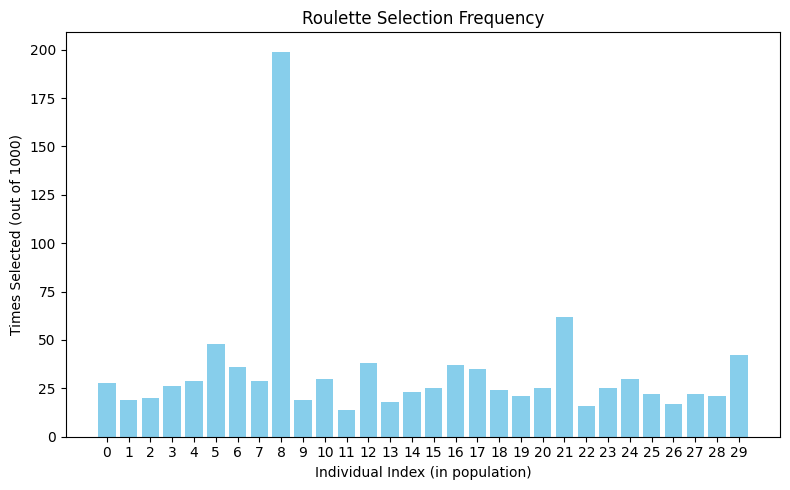

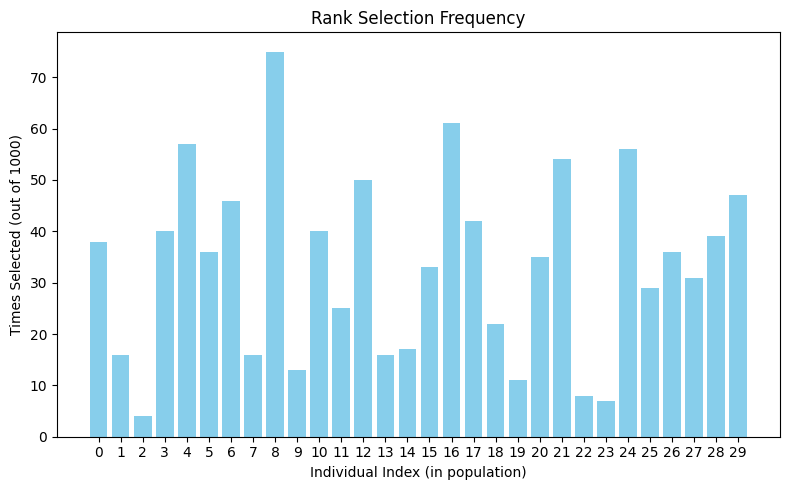

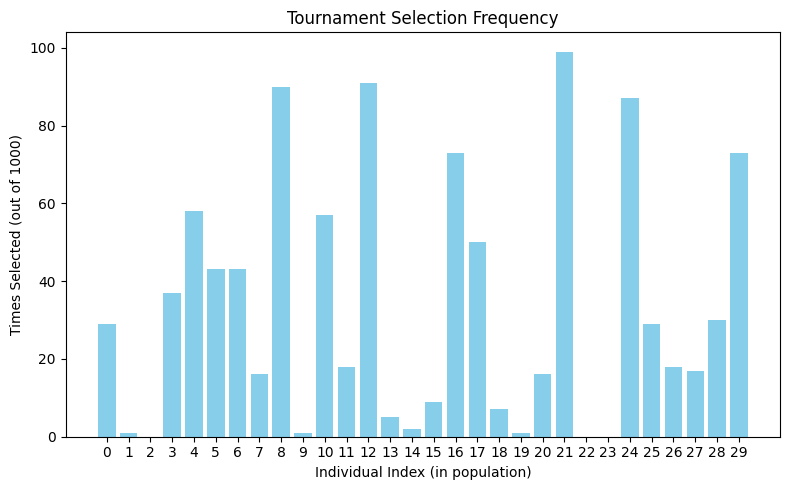

In [69]:
# Step 1: Generate population
population = generate_initial_population(
    population_size,
    players_by_position,
    team_structure,
    budget_limit,
    num_teams
)

# Step 2: Compute fitness
fitness = [ind.fitness for ind in population]

# Step 3: Selection function with tracking
def run_selection(method_func, label, **kwargs):
    selected_indices = []
    for _ in range(1000):
        selected = method_func(population, fitness, num=1, **kwargs)
        idx = population.index(selected[0])
        selected_indices.append(idx)
    count = Counter(selected_indices)
    return label, count

# Step 4: Run all selection methods
label_roulette, count_roulette = run_selection(sel_roulette, "Roulette")
label_rank, count_rank = run_selection(sel_rank, "Rank")
label_tournament, count_tournament = run_selection(sel_tournament, "Tournament", k=3)

# Step 5: Barplot helper
def plot_selection_counts(label, counter):
    indices = list(range(len(population)))
    counts = [counter.get(i, 0) for i in indices]

    plt.figure(figsize=(8, 5))
    plt.bar(indices, counts, color='skyblue')
    plt.xticks(indices)
    plt.xlabel("Individual Index (in population)")
    plt.ylabel("Times Selected (out of 1000)")
    plt.title(f"{label} Selection Frequency")
    plt.tight_layout()
    plt.show()

# Step 6: Plot each method
plot_selection_counts(label_roulette, count_roulette)
plot_selection_counts(label_rank, count_rank)
plot_selection_counts(label_tournament, count_tournament)


In [70]:
population

[<LeagueIndividual fitness=1.0435>,
 <LeagueIndividual fitness=1.4009>,
 <LeagueIndividual fitness=1.8192>,
 <LeagueIndividual fitness=0.9664>,
 <LeagueIndividual fitness=0.8300>,
 <LeagueIndividual fitness=0.8300>,
 <LeagueIndividual fitness=0.9232>,
 <LeagueIndividual fitness=1.1932>,
 <LeagueIndividual fitness=0.1400>,
 <LeagueIndividual fitness=1.4383>,
 <LeagueIndividual fitness=0.9143>,
 <LeagueIndividual fitness=1.1863>,
 <LeagueIndividual fitness=0.5671>,
 <LeagueIndividual fitness=1.2949>,
 <LeagueIndividual fitness=1.2565>,
 <LeagueIndividual fitness=1.2102>,
 <LeagueIndividual fitness=0.7080>,
 <LeagueIndividual fitness=0.9187>,
 <LeagueIndividual fitness=1.2135>,
 <LeagueIndividual fitness=1.3950>,
 <LeagueIndividual fitness=1.1725>,
 <LeagueIndividual fitness=0.4642>,
 <LeagueIndividual fitness=1.5423>,
 <LeagueIndividual fitness=1.6273>,
 <LeagueIndividual fitness=0.7949>,
 <LeagueIndividual fitness=1.0744>,
 <LeagueIndividual fitness=1.1655>,
 <LeagueIndividual fitness=1

# Genetic Algorithm

# Evaluate all possible combinations

In [71]:
results = evaluate_all_combinations(
    players_by_position,
    team_structure,
    budget_limit,
    num_teams,
    population_size,
    generations,
    verbose=True
)

Generation 001 | Best: 0.2770 | Avg: 0.8710
Generation 002 | Best: 0.2770 | Avg: 0.6431
Generation 003 | Best: 0.2100 | Avg: 0.6004
Generation 004 | Best: 0.2100 | Avg: 0.6489
Generation 005 | Best: 0.2100 | Avg: 0.7020
Generation 006 | Best: 0.2100 | Avg: 0.6687
Generation 007 | Best: 0.2100 | Avg: 0.7397
Generation 008 | Best: 0.2100 | Avg: 0.6555
Generation 009 | Best: 0.2100 | Avg: 0.5831
Generation 010 | Best: 0.2100 | Avg: 0.5604
Generation 011 | Best: 0.2100 | Avg: 0.5501
Generation 012 | Best: 0.2100 | Avg: 0.5224
Generation 013 | Best: 0.2100 | Avg: 0.5653
Generation 014 | Best: 0.2100 | Avg: 0.5596
Generation 015 | Best: 0.2100 | Avg: 0.5031
Generation 016 | Best: 0.2100 | Avg: 0.4146
Generation 017 | Best: 0.2100 | Avg: 0.4138
Generation 018 | Best: 0.2100 | Avg: 0.3899
Generation 019 | Best: 0.2100 | Avg: 0.3910
Generation 020 | Best: 0.2100 | Avg: 0.3835
Generation 021 | Best: 0.1400 | Avg: 0.2698
Generation 022 | Best: 0.1069 | Avg: 0.3442
Generation 023 | Best: 0.1069 | 

In [32]:
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by="mean_fitness")
display(df_results)

,selection,crossover,mutation,mean_fitness,std_fitness,best_fitness,time_sec
8,sel_rank,team_crossover,mutation_balance_teams,0.057143,0.000000,0.057143,379.85
14,sel_tournament,team_crossover,mutation_balance_teams,0.057143,0.000000,0.057143,406.03
2,sel_roulette,team_crossover,mutation_balance_teams,0.057143,0.000000,0.057143,417.12
5,sel_roulette,position_crossover,mutation_balance_teams,0.057143,0.000000,0.057143,21.51
11,sel_rank,position_crossover,mutation_balance_teams,0.073730,0.023458,0.057143,10.81
17,sel_tournament,position_crossover,mutation_balance_teams,0.084752,0.039045,0.057143,13.82
7,sel_rank,team_crossover,mutation_regenerate_team,0.090317,0.023458,0.057143,2.41
0,sel_roulette,team_crossover,mutation_swap_players,0.117927,0.015588,0.106904,1.76
10,sel_rank,position_crossover,mutation_regenerate_team,0.117927,0.015588,0.106904,9.21
1,sel_roulette,team_crossover,mutation_regenerate_team,0.117927,0.015588,0.106904,1.93


# BEST SOLUTION

In [33]:
best_solution_final = genetic_algorithm(
    players_by_position=players_by_position,
    team_structure=TEAM_STRUCTURE,
    budget_limit=BUDGET_LIMIT,
    num_teams=NUM_TEAMS,
    population_size=POPULATION_SIZE,
    generations=GENERATIONS,
    selection_fn=sel_roulette,
    crossover_fn=position_crossover,
    mutation_fn=mutation_balance_teams,
    mutation_rate=0.2,
    xo_prob=0.9,
    elitism=True,
    k_tournament=3,
    verbose=True
)


Generation 001 | Best: 0.3307 | Avg: 0.9496
Generation 002 | Best: 0.2286 | Avg: 0.9248
Generation 003 | Best: 0.2286 | Avg: 0.9191
Generation 004 | Best: 0.2100 | Avg: 0.8113
Generation 005 | Best: 0.2100 | Avg: 0.9994
Generation 006 | Best: 0.2100 | Avg: 0.8707
Generation 007 | Best: 0.1069 | Avg: 0.8280
Generation 008 | Best: 0.1069 | Avg: 0.7753
Generation 009 | Best: 0.1069 | Avg: 0.8496
Generation 010 | Best: 0.1069 | Avg: 1.0080
Generation 011 | Best: 0.1069 | Avg: 0.8867
Generation 012 | Best: 0.1069 | Avg: 0.9690
Generation 013 | Best: 0.1069 | Avg: 1.0515
Generation 014 | Best: 0.1069 | Avg: 0.8905
Generation 015 | Best: 0.1069 | Avg: 0.8807
Generation 016 | Best: 0.1069 | Avg: 0.9232
Generation 017 | Best: 0.1069 | Avg: 0.9241
Generation 018 | Best: 0.1069 | Avg: 0.9407
Generation 019 | Best: 0.1069 | Avg: 0.9571
Generation 020 | Best: 0.1069 | Avg: 0.9133
Generation 021 | Best: 0.1069 | Avg: 0.8046
Generation 022 | Best: 0.1069 | Avg: 0.9981
Generation 023 | Best: 0.1069 | 

In [34]:
print("🏆 Best solution found:")
print(best_solution_final)


🏆 Best solution found:
<GASolution fitness=0.0571>


In [35]:
for i, team in enumerate(best_solution_final.individual.league):
    print(f"Team {i+1} - Avg Skill: {team.avg_skill():.2f}")


Team 1 - Avg Skill: 86.43
Team 2 - Avg Skill: 86.43
Team 3 - Avg Skill: 86.29
Team 4 - Avg Skill: 86.43
Team 5 - Avg Skill: 86.43


In [36]:
print_league_details(best_solution_final.individual)


🏟️   (Fitness: 0.0571)

🏆 Team 1
  - GK: Alex Carter | Skill: 85 | Salary: €90M
  - DEF: Maxwell Flores | Skill: 81 | Salary: €72M
  - DEF: Ethan Howard | Skill: 80 | Salary: €70M
  - MID: Ashton Phillips | Skill: 90 | Salary: €110M
  - MID: Nathan Wright | Skill: 92 | Salary: €120M
  - FWD: Chase Murphy | Skill: 86 | Salary: €95M
  - FWD: Colton Gray | Skill: 91 | Salary: €125M
    📊 Avg Skill: 86.43 | 💰 Total Salary: €682M

🏆 Team 2
  - GK: Blake Henderson | Skill: 87 | Salary: €95M
  - DEF: Jaxon Griffin | Skill: 79 | Salary: €65M
  - DEF: Mason Reed | Skill: 82 | Salary: €75M
  - MID: Austin Torres | Skill: 82 | Salary: €80M
  - MID: Dylan Morgan | Skill: 91 | Salary: €115M
  - FWD: Landon Powell | Skill: 89 | Salary: €110M
  - FWD: Sebastian Perry | Skill: 95 | Salary: €150M
    📊 Avg Skill: 86.43 | 💰 Total Salary: €690M

🏆 Team 3
  - GK: Chris Thompson | Skill: 80 | Salary: €80M
  - DEF: Logan Brooks | Skill: 86 | Salary: €95M
  - DEF: Owen Parker | Skill: 88 | Salary: €100M
  -

True